In [16]:
# reload all modules before executing user code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import cv2
from ultralytics import YOLO
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
sys.path.append(os.path.abspath('..'))

from src.const import *
from src.morph import *

In [18]:
# Camera calibration parameters
# Camera Matrix : The focal length and optical centre matrix as shown in intrinsic parameters
K = [[1375.9, 0, 961.61],
    [0, 988.9, 570.19],
    [0, 0, 1]]
K = np.array(K)
# Distortion Coefficients : The distortion coefficients (k1, k2, p1, p2, k3) represent the lens distortion
dist_coeffs =  [[   0.088421   ,  0.63517,  0.00033029 ,   0.004898   ,  -3.4166]]
dist_coeffs = np.array(dist_coeffs)

In [19]:
def warp_image(frame, corners, board_size=(800, 800)):
    
    # define the destination points for the transformation (clockwise from top-left)
    dest_points = np.array([
                            [0, 0],
                            [board_size[0] - 1, 0],
                            [board_size[0] - 1, board_size[1] - 1],
                            [0, board_size[1] - 1]
                        ], dtype="float32")

    # reorder corners for clockwise from top-left
    src_pts = np.array([
                        [corners["h8"][0], corners["h8"][1]],
                        [corners["h1"][0], corners["h1"][1]],
                        [corners["a1"][0], corners["a1"][1]],
                        [corners["a8"][0], corners["a8"][1]] 
                    ], dtype=np.float32)

    perspect_matrix = cv2.getPerspectiveTransform(src_pts, dest_points)
    warped_image = cv2.warpPerspective(frame, perspect_matrix, board_size)

    return warped_image

def warp_image2(frame, corners, camera_matrix=None, distor_coeffs=None, board_size=(800, 800)):
    """
    Undistort using camera calibration then compute perspective warp from the undistorted corner points.
    This reduces skew/deformation caused by lens distortion / camera pose.
    """

    h_img, w_img = frame.shape[:2]

    # destination (clockwise from top-left)
    dest_points = np.array([
        [0, 0],
        [board_size[0] - 1, 0],
        [board_size[0] - 1, board_size[1] - 1],
        [0, board_size[1] - 1]
    ], dtype="float32")

    # original source ordering used elsewhere (clockwise from top-left)
    src_pts = np.array([
        [corners["h8"][0], corners["h8"][1]],
        [corners["h1"][0], corners["h1"][1]],
        [corners["a1"][0], corners["a1"][1]],
        [corners["a8"][0], corners["a8"][1]]
    ], dtype=np.float32)

    # If calibration available, undistort the image and the corner points.
    # Use getOptimalNewCameraMatrix to reduce black regions after undistort.
    if camera_matrix is not None and distor_coeffs is not None:
        new_camera_mtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, distor_coeffs, (w_img, h_img), 1)
        undistorted_img = cv2.undistort(frame, camera_matrix, distor_coeffs, None, new_camera_mtx)

        # undistortPoints returns normalized/image points when P is provided (pixel coords in undistorted image)
        pts_for_undist = src_pts.reshape(-1, 1, 2).astype(np.float32)
        undist_src = cv2.undistortPoints(pts_for_undist, camera_matrix, distor_coeffs, P=new_camera_mtx).reshape(-1, 2).astype(np.float32)

        M = cv2.getPerspectiveTransform(undist_src, dest_points)
        warped_image = cv2.warpPerspective(undistorted_img, M, board_size)
    else:
        # fallback to original behavior if no calibration provided
        M = cv2.getPerspectiveTransform(src_pts, dest_points)
        warped_image = cv2.warpPerspective(frame, M, board_size)

    return warped_image

def segmented_grid_chessboard(warped_frame):

    h, w = warped_frame.shape[:2]

    # convert to grayscale and detect edges
    gray = cv2.cvtColor(warped_frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # automatic Canny thresholds based on median
    med = np.median(blur)
    lower = int(max(0, 0.66 * med))
    upper = int(min(255, 1.33 * med))
    edges = cv2.Canny(blur, lower, upper)

    # probabilistic Hough line transform
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=80,
                            minLineLength=60, maxLineGap=20)
    
    segs = lines.reshape(-1, 4)
    # compute direction vectors of each segment by (x2 - x1, y2 - y1)
    vecs = segs[:, 2:4] - segs[:, :2]
    print(vecs.shape)  # (N, 2) : N vectors, each with 2 components (dx, dy)

    # compute angle of each segment
    dx, dy = vecs[:, 0].astype(float), vecs[:, 1].astype(float)
    angles = np.arctan2(dy, dx)

    """
    extend detected nearly-vertical and nearly-horizontal segments 
    to full image borders to form a grid
    """
    
    class_tol = np.deg2rad(1)  # classify lines within 15 degrees as horizontal/vertical

    # get indices of lines with +- 15dg vert or horiz
    vert_idx = np.where(np.abs(np.abs(angles) - np.pi/2) < class_tol)[0]
    horiz_idx = np.where(np.abs(angles) < class_tol)[0]
    print(f"Number of vertical lines: {len(vert_idx)}")
    print(f"Number of horizontal lines: {len(horiz_idx)}")

    # use segs to define a x-y axis system based on midpoints of detected segments
    xs = np.array([(segs[i, 0] + segs[i, 2]) / 2.0 for i in vert_idx]) if vert_idx.size else np.array([])
    ys = np.array([(segs[i, 1] + segs[i, 3]) / 2.0 for i in horiz_idx]) if horiz_idx.size else np.array([])

    # cluster close lines to avoid duplicate nearby grid lines
    def cluster_1d(vals, eps=10):
        if vals.size == 0:
            return np.array([])
        vals = vals.reshape(-1, 1)
        clustering = DBSCAN(eps=eps, min_samples=1).fit(vals)
        clusters = []
        for lab in np.unique(clustering.labels_):
            members = vals[clustering.labels_ == lab].flatten()
            clusters.append(members.mean())
        return np.array(sorted(clusters))

    x_lines = cluster_1d(xs, eps=12)
    y_lines = cluster_1d(ys, eps=12)
    print(f"Number of vertical lines clustered: {len(x_lines)}")
    print(f"Number of horizontal lines clustered: {len(y_lines)}")

    if len(x_lines) < 9 or len(y_lines) < 9:
        # extrapolate missing lines to ensure at least 9 lines in each direction
        print("Not enough grid lines detected, extrapolating missing lines...")
        if len(x_lines) < 9 and len(x_lines) >= 2:
            x_step = np.median(np.diff(x_lines))
            while len(x_lines) < 9:
                if len(x_lines) < 9:
                    x_lines = np.insert(x_lines, 0, x_lines[0] - x_step)
                if len(x_lines) < 9:
                    x_lines = np.append(x_lines, x_lines[-1] + x_step)
        if len(y_lines) < 9 and len(y_lines) >= 2:
            y_step = np.median(np.diff(y_lines))
            while len(y_lines) < 9:
                if len(y_lines) < 9:
                    y_lines = np.insert(y_lines, 0, y_lines[0] - y_step)
                if len(y_lines) < 9:
                    y_lines = np.append(y_lines, y_lines[-1] + y_step)
    print(f"Final vertical lines: {len(x_lines)}")
    print(f"Final horizontal lines: {len(y_lines)}")

    # compute intersection points of the grid lines
    inters_pts = []
    for xv in x_lines:
        for yv in y_lines:
            xi = int(round(np.clip(xv, 0, w-1)))
            yi = int(round(np.clip(yv, 0, h-1)))
            inters_pts.append((xi, yi))

    external_pts = [
        (int(round(np.clip(x_lines[0], 0, w-1))), int(round(np.clip(y_lines[0], 0, h-1)))),
        (int(round(np.clip(x_lines[-1], 0, w-1))), int(round(np.clip(y_lines[0], 0, h-1)))),
        (int(round(np.clip(x_lines[0], 0, w-1))), int(round(np.clip(y_lines[-1], 0, h-1)))),
        (int(round(np.clip(x_lines[-1], 0, w-1))), int(round(np.clip(y_lines[-1], 0, h-1))))
    ]

    min_x, max_x, min_y, max_y = external_pts[0][0], external_pts[3][0], external_pts[0][1], external_pts[3][1]

    line_img = warped_frame.copy()

    for i, (x1, y1, x2, y2) in enumerate(segs):
        cv2.line(line_img, (int(x1), int(y1)), (int(x2), int(y2)), RED, 5)

    for xv in x_lines:
        x = int(round(np.clip(xv, 0, w-1)))
        # cv2.line(line_img2, (x, 0), (x, h-1), BLUE, 2)
        cv2.line(warped_frame, (x, min_y), (x, max_y), BLUE, 2)

    for yv in y_lines:
        y = int(round(np.clip(yv, 0, h-1)))
        # cv2.line(warped_frame, (0, y), (w-1, y), BLUE, 2)
        cv2.line(warped_frame, (min_x, y), (max_x, y), BLUE, 2)

    for (xi, yi) in inters_pts:
        cv2.circle(warped_frame, (xi, yi), 6, ORANGE, -1)


    for i, (xi, yi) in enumerate(external_pts):
        cv2.circle(warped_frame, (xi, yi), 6, BLACK, 4)

    axs, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Detected Lines')
    ax[1].imshow(cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB))
    ax[1].set_title('Grid Intersections')
    plt.show()

    return inters_pts, external_pts

def cleaning_cell_chessboard(warped_frame):

    warped_frame = cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB)

    range_white = 45        
    range_black = 45        
    lower_white = [max(0, c - range_white) for c in WHITE_CHESS]
    upper_white = [min(240, c + range_white) for c in WHITE_CHESS] 
    lower_black = [max(0, c - range_black) for c in BLACK_CHESS2] 
    upper_black = [min(240, c + range_black) for c in BLACK_CHESS2]

    # exclude (put at 0=black) white pixels in the specified range of chessboard
    exclude_white_mask = exclude_color_mask(warped_frame, lower_white, upper_white)

    # removes white areas from the image
    exclude_white_frame = cv2.bitwise_and(warped_frame, warped_frame, mask=exclude_white_mask)

    # exclude (put at 0=black) black pixels in the specified range of chessboard
    exclude_black_mask = exclude_color_mask(warped_frame, lower_black, upper_black)

    # removes black areas from the image
    exclude_black_frame = cv2.bitwise_and(warped_frame, warped_frame, mask=exclude_black_mask)

    exclude_white_black = cv2.bitwise_and(exclude_white_frame, exclude_black_frame)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
    axs[0,0].imshow(exclude_white_mask)
    axs[0,0].set_title('Exclude White Mask')
    axs[0,1].imshow(exclude_white_frame)
    axs[0,1].set_title('Exclude White Frame')
    axs[1,0].imshow(exclude_black_mask)
    axs[1,0].set_title('Exclude Black Mask')
    axs[1,1].imshow(exclude_black_frame)
    axs[1,1].set_title('Exclude Black Frame')
    plt.show()

    clean_exclude_white_black = dilate(erode(exclude_white_black, 3, 8), 3, 10)

    return clean_exclude_white_black


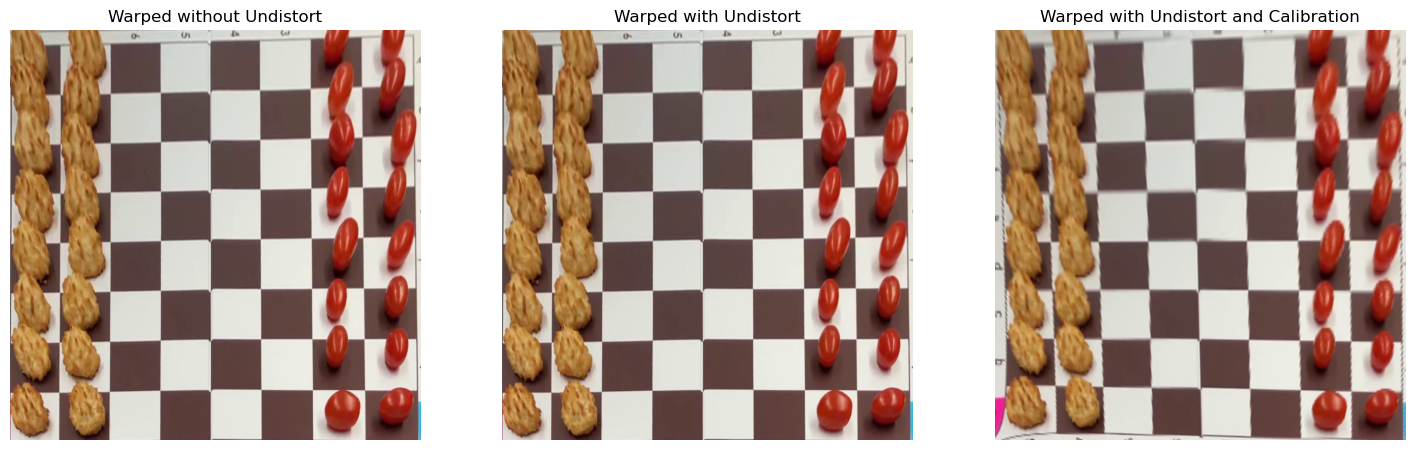

(70, 2)
Number of vertical lines: 40
Number of horizontal lines: 20
Number of vertical lines clustered: 9
Number of horizontal lines clustered: 9
Final vertical lines: 9
Final horizontal lines: 9


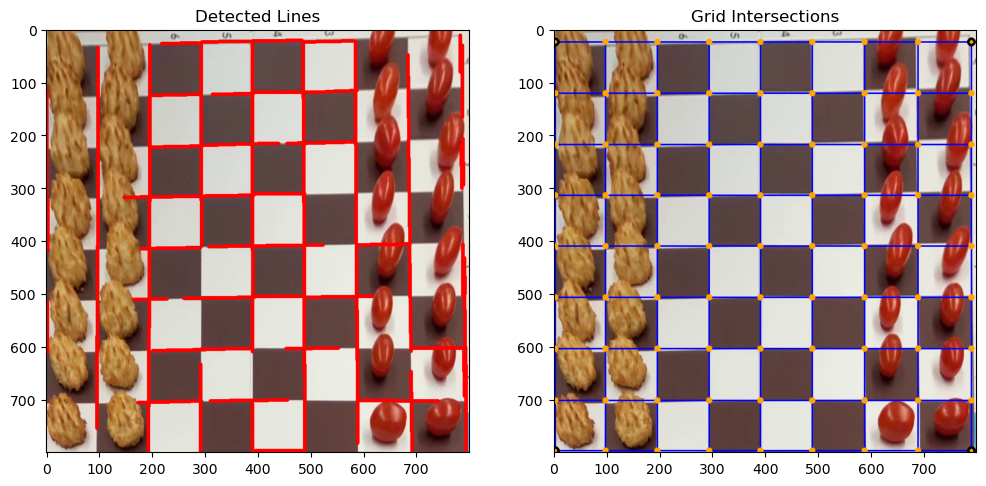

(70, 2)
Number of vertical lines: 40
Number of horizontal lines: 20
Number of vertical lines clustered: 9
Number of horizontal lines clustered: 9
Final vertical lines: 9
Final horizontal lines: 9


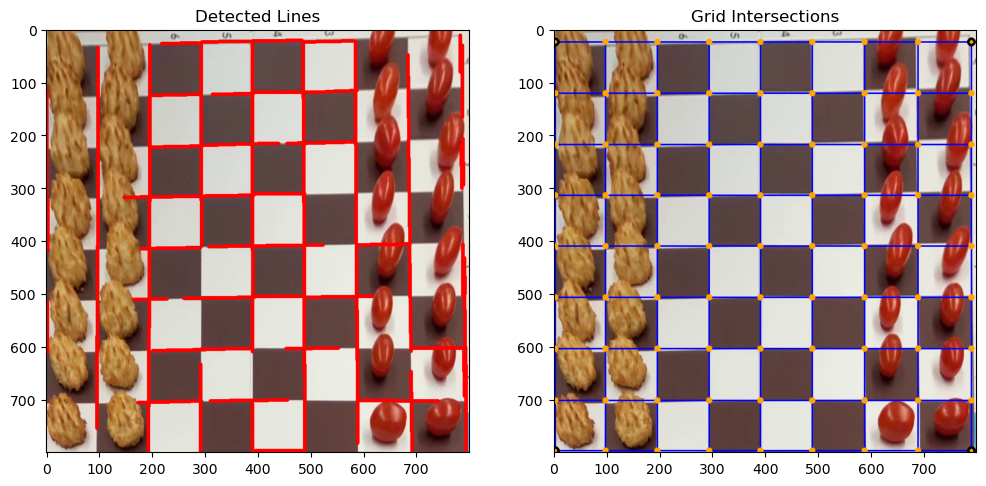

(61, 2)
Number of vertical lines: 18
Number of horizontal lines: 14
Number of vertical lines clustered: 7
Number of horizontal lines clustered: 6
Not enough grid lines detected, extrapolating missing lines...
Final vertical lines: 9
Final horizontal lines: 9


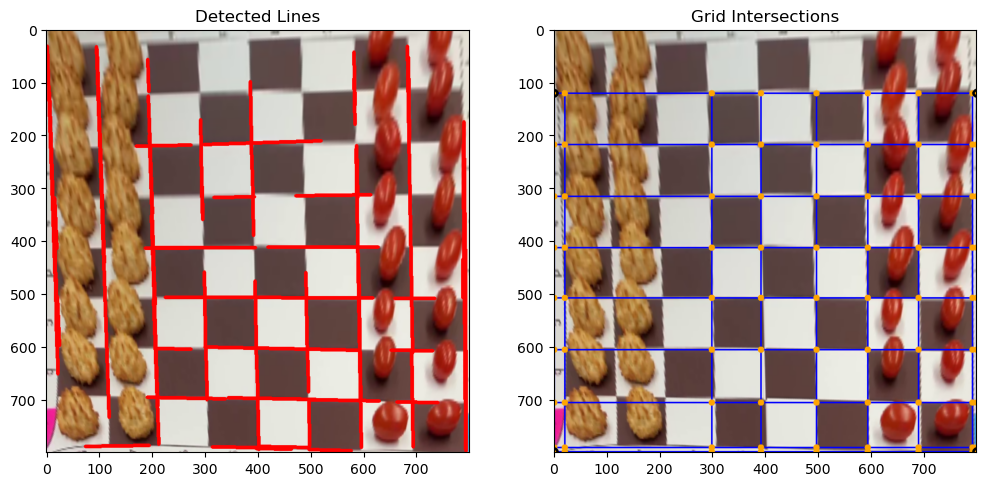

([(0, 121),
  (0, 218),
  (0, 316),
  (0, 413),
  (0, 508),
  (0, 606),
  (0, 706),
  (0, 791),
  (0, 799),
  (20, 121),
  (20, 218),
  (20, 316),
  (20, 413),
  (20, 508),
  (20, 606),
  (20, 706),
  (20, 791),
  (20, 799),
  (298, 121),
  (298, 218),
  (298, 316),
  (298, 413),
  (298, 508),
  (298, 606),
  (298, 706),
  (298, 791),
  (298, 799),
  (391, 121),
  (391, 218),
  (391, 316),
  (391, 413),
  (391, 508),
  (391, 606),
  (391, 706),
  (391, 791),
  (391, 799),
  (496, 121),
  (496, 218),
  (496, 316),
  (496, 413),
  (496, 508),
  (496, 606),
  (496, 706),
  (496, 791),
  (496, 799),
  (593, 121),
  (593, 218),
  (593, 316),
  (593, 413),
  (593, 508),
  (593, 606),
  (593, 706),
  (593, 791),
  (593, 799),
  (689, 121),
  (689, 218),
  (689, 316),
  (689, 413),
  (689, 508),
  (689, 606),
  (689, 706),
  (689, 791),
  (689, 799),
  (791, 121),
  (791, 218),
  (791, 316),
  (791, 413),
  (791, 508),
  (791, 606),
  (791, 706),
  (791, 791),
  (791, 799),
  (799, 121),
  (79

In [21]:
corners =  {'h8': [496, 324],
            'h1': [1290, 338],
            'a8': [242, 815],
            'a1': [1527, 809]}


frame = cv2.imread('../img_test/frame_corners.png')

warped_frame1 = warp_image(frame, corners, board_size=(800, 800))

warped_frame2 = warp_image2(frame, corners, board_size=(800, 800))

warped_frame3 = warp_image2(frame, corners, board_size=(800, 800), camera_matrix=K, distor_coeffs=dist_coeffs)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(warped_frame1, cv2.COLOR_BGR2RGB))
plt.title('Warped without Undistort')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(warped_frame2, cv2.COLOR_BGR2RGB))
plt.title('Warped with Undistort')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(warped_frame3, cv2.COLOR_BGR2RGB))
plt.title('Warped with Undistort and Calibration')
plt.axis('off')
plt.show()

segmented_grid_chessboard(warped_frame1)
segmented_grid_chessboard(warped_frame2)
segmented_grid_chessboard(warped_frame3)